<a href="https://colab.research.google.com/github/b2232150/prmn2024b/blob/main/dm/sklearn_pca.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# データマイニング第9回 9-1

B2232150 藤田玄

In [ ]:
from sklearn import datasets
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import functools
import shutil

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
# Google Colabを使っている場合には、ドライブのマウントを行います
from google.colab import drive
from pathlib import Path
drive.mount('/content/drive')
data_home_path = Path('/content/drive/MyDrive/データマイニング/dm_9')
tuning_json = data_home_path / 'tmp' / 'tuning.json'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
class Data:

  def __init__(self, X:np.ndarray):
    self.X = X
    self.size = self.X.shape[1]
    self.width = int(np.sqrt(self.X.shape[1]))

  def plot(self, plot_idx: list, title: str|None = None):
    """
    データを表示する
    data_name: 表示するデータの名前
    plot_idx: 表示するデータのインデックスリスト
    title: タイトル
    """
    if title is not None:
      print(title)
    cols = len(plot_idx)
    fig, axes = plt.subplots(nrows=1, ncols=cols, figsize=(5, 2))
    for count, idx in enumerate(plot_idx):
      axes[count].imshow(self.X[idx].reshape(self.width, self.width), cmap='gray')
    plt.show()

# データとラベルをまとめて扱うための構造体
class LabeledData(Data):

  def __init__(self, X: np.ndarray, y: np.ndarray):
    super().__init__(X)
    self.y = y

  def select_labels(self, positive_labels: list):
    """
    指定したラベルのみを切り抜いたデータセットを返す
    """

    mask = np.isin(self.y, positive_labels)

    return LabeledData(self.X[mask], self.y[mask])

  def limit_data(self, limit):
    """
    データ数を削減する
    """

    return LabeledData(self.X[:limit], self.y[:limit])

  def train_test_split(self, test_size=0.2, random_state=42, view=False):
    """
    訓練データとテストデータを作成する
    dataSet: データセット
    test_size: テストデータの割合
    random_state: 乱数シード
    """

    # 訓練データとテストデータに分割
    X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, test_size=test_size, random_state=random_state)

    if view:

      print("┌--train-test-size--")
      print("│train: ", X_train.shape)
      print("│test: ", X_test.shape)
      print("└-------------------")

    return LabeledData(X_train, y_train), LabeledData(X_test, y_test)

In [ ]:
def train_test_split_oc(normal: LabeledData, anomaly: LabeledData, test_size=0.2, random_state=42, view=False):
    """
    訓練データとテストデータを作成し、異常検知用に加工する
    normal: 正常なデータとラベル
    anomaly: 異常なデータとラベル
    test_size: テストデータの割合
    random_state: 乱数シード
    """

    # 訓練データとテストデータに分割
    normal_train, normal_test = normal.train_test_split(test_size=test_size, random_state=random_state)

    X_train = normal_train.X
    y_train = normal_test.y

    # 結合して訓練データとテストデータを作成
    X_test = np.vstack([normal_test.X, anomaly.X])

    # y_test = np.hstack([y_nor_test, y_ano_test])
    y_test = np.hstack([
      np.full(len(normal_test.y), 0),
      np.full(len(anomaly.y), 1)
    ])

    if view:

      print("┌--train-test-size--")
      print("│train: ", X_train.shape)
      print("│test: ", X_test.shape)
      print("└-------------------")

    return LabeledData(X_train, y_train), LabeledData(X_test, y_test)

In [ ]:
def mnist_load(name='mnist_784', version=1, view=False):
  """
  mnistをロードする
  """

  mnist = datasets.fetch_openml(name=name, version=version, as_frame=False, data_home=data_home_path)
  X = mnist.data
  X = MinMaxScaler().fit_transform(X) # x = x/255
  y = mnist.target
  width = int(np.sqrt(X.shape[1]))

  if view:
    print("┌-mnist-X--")
    print("│ type: ", type(X))
    print("│ shape: ", X.shape)
    print("│ width: ", width)
    print("├-mnist-y--")
    print("│ type: ", type(y))
    print("│ shape: ", y.shape)
    print("└--------------")

  return LabeledData(X, y)

In [ ]:
mnist = mnist_load()

data_limit = 1000

mnist1 = mnist.select_labels(['1'])
mnist1 = mnist1.limit_data(data_limit)
mnist7 = mnist.select_labels(['7'])
mnist7 = mnist7.limit_data(data_limit)
train, test = train_test_split_oc(mnist1, mnist7)

In [ ]:
# psnr値を計算 (正規化済みデータを想定)
def calc_psnr(all, original, reconstructed):
  """
  psnr値を計算する
  all: 全体データ
  original: オリジナルデータ
  reconstructed: ノイズ削減後のデータ
  """

  dx = original-reconstructed
  mse = np.diag(dx@dx.T)/all.shape[0]
  if np.any(mse == 0): return 100
  return 10*np.log10(1/mse)

In [ ]:
class PcaDetector:

  def __init__(self, train, test, all):

    self.X_train = train.X
    self.y_train = train.y
    self.X_test = test.X
    self.y_test = test.y
    self.X = all.X

  def fit_predict(self, p, alpha, view=False):
    """
    PCAインスタンスを作成し、学習させる(訓練)
    異常を検出し、psnrとconfusion matrixを出力する(テスト)
    p: 次元圧縮後の次元数
    alpha: 正常と異常の閾値
    """
    # PCAの学習
    pca = PCA(n_components=p)
    ex = np.mean(self.X_train, axis=0)
    pca.fit(self.X_train-ex)

    # テストデータをノイズ削減したもの(reconstructed)を取得
    pc = pca.transform(self.X_test)
    X_test_reco = pca.inverse_transform(pc)
    psnr_reco = calc_psnr(self.X, self.X_test, X_test_reco)

    self.y_pred = psnr_reco < alpha

    if view:
      print("┌--psnr-----")
      print(psnr_reco)
      print("└-----------")

    return self.y_test, self.y_pred

In [ ]:
def cm_scores(y_test, y_pred, view=False):
  """
  accuracy, precision, recall, f-scoreを計算して返す
  """

  cm = confusion_matrix(y_test, y_pred)
  tn, fp, fn, tp = cm.ravel() # 2次元numpy配列を1次元numpy配列に変換してアンパック
  accuracy = (tp + tn) / (tp + tn + fp + fn)
  precision = tp / (tp + fp) if (tp + fp) != 0 else 0
  recall = tp / (tp + fn) if (tp + fn) != 0 else 0
  f_score = 2 * precision * recall / (precision + recall) if (precision + recall) != 0 else 0

  if view:
    print("┌-confusion matrix--")
    print("[[TN   FP]\n [ FN TP]]")
    print(cm)
    print("└-------------------")
    print("┌--evaluation--")
    print("Accuracy: ", accuracy)
    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F-score: ", f_score)
    print("└-------------")

  return accuracy, precision, recall, f_score

In [ ]:
class ParamSearcher:
    """
    探索範囲を指定して最適なパラメータを探索し、複数の指標で一括評価するクラス
    """
    def __init__(self, log_file_path):
        self.log_file_path = Path(log_file_path)
        self.log = [] # メモリ上ではリスト(dicts)として管理
        # 評価関数を辞書で定義
        self.scorer = {
            'accuracy': accuracy_score,
            'precision': precision_score,
            'recall': recall_score,
            'f-score': f1_score,
        }

    def save(self):
        """現在のログをファイルに保存"""
        # リスト内に辞書が入っている構造であれば、Polarsが自動的にカラムを生成します
        pl.DataFrame(self.log).write_json(self.log_file_path)

    def load(self):
        """前回のログをファイルから読み込む"""
        if self.log_file_path.exists():
            try:
                df = pl.read_json(self.log_file_path)
                self.log = df.to_dicts()
                print(f"{len(self.log)} items read from file.")
                return 'success'
            except Exception as e:
                print(f"Error reading log file: {e}")
                self.log = []
                return 'fail'
        else:
            self.log = []
            print("Log file does not exist.")
            return 'new'

    def run(self, model, param_grid, batch_save_size=10):
        """
        パラメータ探索を実行する

        Args:
            model: fit_predictメソッドを持つモデルオブジェクト
            param_grid: 探索するパラメータの辞書 {param_name: [list of values]}
            batch_save_size: ログをファイルに保存する間隔
        """
        # 前回データを読み込み
        status = self.load()
        print("load status: ", status)

        keys = list(param_grid.keys())
        values = list(param_grid.values())
        # パラメータの全組み合わせを作成
        param_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

        start = len(self.log)
        total = len(param_combinations)

        if start >= total:
            print("Already processed all combinations.")
            return pl.DataFrame(self.log)

        print(f"Starting search from index {start}/{total}...")

        # 未処理の組み合わせを実行
        for i, params in enumerate(param_combinations[start:], start=start):

            y_test, y_pred = model.fit_predict(**params)

            # パラメータを記録
            record = params.copy()

            # 評価結果を記録
            for score_name, score_func in self.scorer.items():

                # NOTE: accuracyだけzero_division引数を受け付けないので、無理やり押し込んでいる
                record[score_name] = score_func(y_test, y_pred, zero_division=0) if score_name != 'accuracy' else score_func(y_test, y_pred)

            self.log.append(record)

            # 定期的に保存
            if (i + 1) % batch_save_size == 0:
                print(f"Processed {i + 1}/{total}...")
                self.save()

        # 最終結果を保存
        self.save()
        print("Search completed.")

        return pl.DataFrame(self.log)

    def show(self, param_x, param_y, score_col, annot=True):
        """
        探索結果をヒートマップで可視化する

        Args:
            param_x: x軸にするパラメータ名
            param_y: y軸にするパラメータ名
            score_col: ヒートマップの値にする評価指標カラム名 ('accuracy', 'f-score' etc.)
        """
        status = self.load()
        if not self.log:
            print("Log file not found or empty.")
            return

        # ファイルから読み込むか、メモリ上のログを使用
        df = pl.DataFrame(self.log)

        # カラムの存在確認
        if score_col not in df.columns:
            print(f"Error: Column '{score_col}' not found. Available columns: {df.columns}")
            return
        if param_x not in df.columns or param_y not in df.columns:
            print(f"Error: Parameters '{param_x}' or '{param_y}' not found.")
            return

        # ベストスコアの表示
        if df.height > 0:
            max_score = df.select(pl.col(score_col).max()).item()
            print(f"Best {score_col}: {max_score}")
            best_row = df.filter(pl.col(score_col) == max_score)
            print(best_row)

            # ピボットテーブルの作成と可視化
            try:
                # Polarsでピボットし、Pandasに変換してSeabornで描画
                pivot_df = df.pivot(values=score_col, index=param_y, columns=param_x)

                # ピボット結果をPandasに変換し、インデックスを設定
                pandas_df = pivot_df.to_pandas().set_index(param_y)

                # 可視化
                plt.figure(figsize=(10, 8))
                ax = sns.heatmap(pandas_df,
                                 annot=annot,
                                 cmap="viridis",
                                 fmt=".3f",
                                 linewidth=0.5,
                                 linecolor='black',
                                 )
                self._emphasize_max(pandas_df, ax)
                plt.title(f"Param Tuning Result ({score_col}): {param_x} vs {param_y}")
                plt.xlabel(param_x)
                plt.ylabel(param_y)
                plt.show()

            except Exception as e:
                print(f"Error during visualization: {e}")
                print("Make sure 'param_x' and 'param_y' correspond to the parameters used in search.")
        else:
            print("No data to visualize.")

    def _emphasize_max(self, data, ax):
        from matplotlib.patches import Rectangle
        # --- 最大値の強調表示処理 ---
        # データ行列を取得
        data_matrix = data.values
        # 最大値を取得（NaNがある場合は無視）
        max_val = np.nanmax(data_matrix)

        # 最大値と一致するインデックスを取得 (行, 列)
        # np.argwhereは条件を満たすインデックスのリストを返す
        max_indices = np.argwhere(data_matrix == max_val)

        for row_idx, col_idx in max_indices:
            # ヒートマップのセルに合わせて赤い枠線を追加
            # Rectangle((x, y), width, height, ...)
            # x軸: col_idx, y軸: row_idx (左上が原点でyは下向き)
            rect = Rectangle(
                (col_idx, row_idx), 1, 1,
                fill=False,
                edgecolor='black',
                lw=2,
                clip_on=False
            )
            ax.add_patch(rect)

In [ ]:
#保存
if input("are you sure to save tuning.json? (y/n)") == "y":
  shutil.copy(tuning_json, data_home_path / 'tuning' / 'detection.json')

are you sure to save tuning.json? (y/n)y


In [ ]:
#読み込み
if input("are you sure to load tuning.json? (y/n)") == "y":
  shutil.copy(data_home_path / 'tuning' / 'dummy.json', tuning_json)

are you sure to load validation.json? (y/n)n


In [ ]:
#削除
if input("are you sure to delete tuning.json? (y/n)") == "y":
  try:
    tuning_json.unlink()
  except FileNotFoundError as e:
    print("already deleted (or typo)  : ", e)

are you sure to delete tuning.json? (y/n)y


In [ ]:
# 探索器のインスタンス化
searcher = ParamSearcher(tuning_json)

# パラメータ範囲の定義
param_grid = {
    'p': np.arange(1, 784, 10),
    'alpha': np.arange(0, 200, 10),
}

# 実行
searcher.run(PcaDetector(train, test, mnist), param_grid)

Log file does not exist.
load status:  new
Starting search from index 0/1580...
Processed 10/1580...
Processed 20/1580...
Processed 30/1580...
Processed 40/1580...
Processed 50/1580...
Processed 60/1580...
Processed 70/1580...
Processed 80/1580...
Processed 90/1580...
Processed 100/1580...
Processed 110/1580...
Processed 120/1580...
Processed 130/1580...
Processed 140/1580...
Processed 150/1580...
Processed 160/1580...
Processed 170/1580...
Processed 180/1580...
Processed 190/1580...
Processed 200/1580...
Processed 210/1580...
Processed 220/1580...
Processed 230/1580...
Processed 240/1580...
Processed 250/1580...
Processed 260/1580...
Processed 270/1580...
Processed 280/1580...
Processed 290/1580...
Processed 300/1580...
Processed 310/1580...
Processed 320/1580...
Processed 330/1580...
Processed 340/1580...
Processed 350/1580...
Processed 360/1580...
Processed 370/1580...
Processed 380/1580...
Processed 390/1580...
Processed 400/1580...
Processed 410/1580...
Processed 420/1580...
Proce

p,alpha,accuracy,precision,recall,f-score
i64,i64,f64,f64,f64,f64
1,0,0.166667,0.0,0.0,0.0
1,10,0.166667,0.0,0.0,0.0
1,20,0.166667,0.0,0.0,0.0
1,30,0.638333,0.971667,0.583,0.72875
1,40,0.833333,0.833333,1.0,0.909091
…,…,…,…,…,…
781,150,0.981667,0.980354,0.998,0.989098
781,160,0.981667,0.980354,0.998,0.989098
781,170,0.981667,0.980354,0.998,0.989098


In [ ]:
# 探索器のインスタンス化
searcher = ParamSearcher(tuning_json)

1580 items read from file.
Best accuracy: 0.9875
shape: (2, 6)
┌─────┬───────┬──────────┬───────────┬────────┬──────────┐
│ p   ┆ alpha ┆ accuracy ┆ precision ┆ recall ┆ f-score  │
│ --- ┆ ---   ┆ ---      ┆ ---       ┆ ---    ┆ ---      │
│ i64 ┆ i64   ┆ f64      ┆ f64       ┆ f64    ┆ f64      │
╞═════╪═══════╪══════════╪═══════════╪════════╪══════════╡
│ 211 ┆ 50    ┆ 0.9875   ┆ 0.989076  ┆ 0.996  ┆ 0.992526 │
│ 221 ┆ 50    ┆ 0.9875   ┆ 0.99005   ┆ 0.995  ┆ 0.992519 │
└─────┴───────┴──────────┴───────────┴────────┴──────────┘


/tmp/ipython-input-881989466.py:127: DeprecationWarning: the argument `columns` for `DataFrame.pivot` is deprecated. It was renamed to `on` in version 1.0.0.
  pivot_df = df.pivot(values=score_col, index=param_y, columns=param_x)


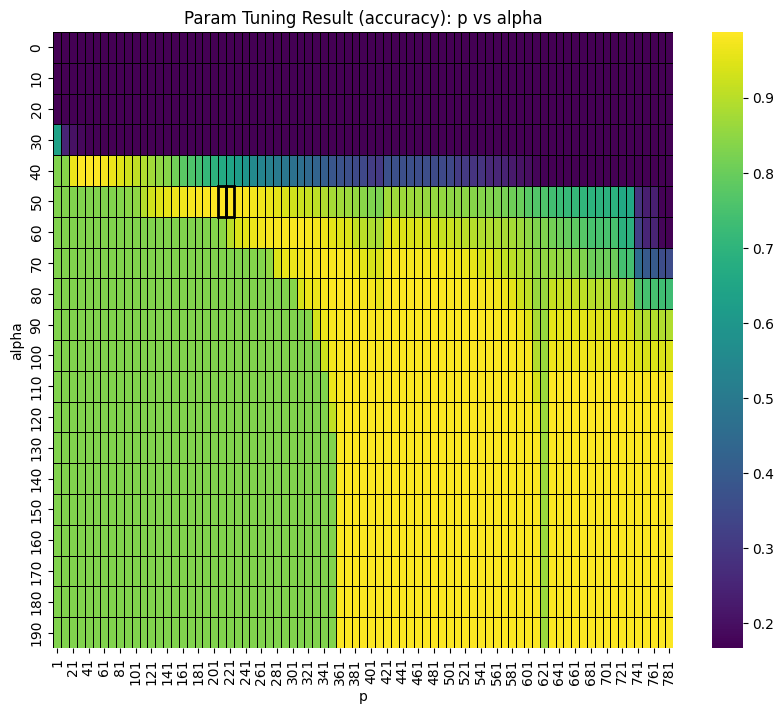

In [ ]:
#  結果の可視化
searcher.show(param_x='p', param_y='alpha', score_col='accuracy', annot=False)

## 探索結果の一覧表示
[パラメータの探索結果データ](https://drive.google.com/drive/folders/1-0fq7J_ZJKVhlWjhdznksMwa17fIDyWL?usp=sharing)です。  
念のため添付しておきます。  

In [ ]:
tuning_files = (data_home_path / 'tuning').iterdir()
for file in tuning_files:
  print(file)

/content/drive/MyDrive/データマイニング/dm_10/tuning/rbf_classification.json
/content/drive/MyDrive/データマイニング/dm_10/tuning/rbf_detection.json
/content/drive/MyDrive/データマイニング/dm_10/tuning/linear_classification.json


450 items read from file.
Best f-score: 0.9511568123393316
shape: (1, 7)
┌────────┬──────────┬────────┬──────────┬───────────┬────────┬──────────┐
│ kernel ┆ gamma    ┆ nu     ┆ accuracy ┆ precision ┆ recall ┆ f-score  │
│ ---    ┆ ---      ┆ ---    ┆ ---      ┆ ---       ┆ ---    ┆ ---      │
│ str    ┆ f64      ┆ f64    ┆ f64      ┆ f64       ┆ f64    ┆ f64      │
╞════════╪══════════╪════════╪══════════╪═══════════╪════════╪══════════╡
│ rbf    ┆ 0.015625 ┆ 0.0625 ┆ 0.984167 ┆ 0.978836  ┆ 0.925  ┆ 0.951157 │
└────────┴──────────┴────────┴──────────┴───────────┴────────┴──────────┘


/tmp/ipython-input-476195568.py:127: DeprecationWarning: the argument `columns` for `DataFrame.pivot` is deprecated. It was renamed to `on` in version 1.0.0.
  pivot_df = df.pivot(values=score_col, index=param_y, columns=param_x)


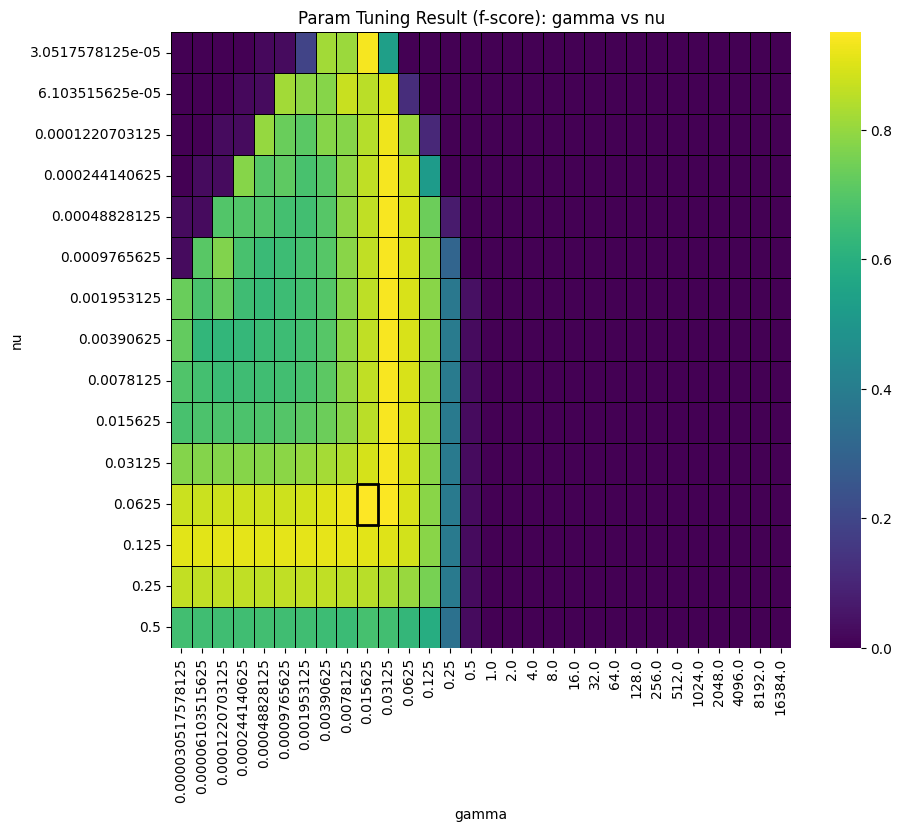

In [ ]:
# 探索器のインスタンス化
shower = ParamSearcher(data_home_path / 'tuning' / 'rbf_detection.json')
shower.show(param_x='gamma', param_y='nu', score_col='f-score', annot=False)